In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from iminuit import Minuit

In [2]:
data1_path = "https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2024/data/ParameterEstimation_Ex1.txt"
data = pd.read_csv(data1_path, names=["Col1"]).values.T[0]

parab_min = -0.95
parab_max = 0.95
n_bins = 50
data_counts, data_edges = np.histogram(
    data, bins=n_bins, range=(parab_min, parab_max), density=True
)
data_centers = (data_edges[1:] + data_edges[:-1]) / 2

In [3]:
def norm_pdf_parab(x, alpha, beta):
    norm_const = 1 / (1.9 + 0.571583 * beta)
    return norm_const * (1 + alpha * x + beta * x**2)


def llh_parab_pdf(x, alpha, beta):
    fit_vals = norm_pdf_parab(x, alpha, beta)
    return 2 * np.sum(-np.log(fit_vals))


llh_parab_data = lambda alpha, beta: llh_parab_pdf(x=data, alpha=alpha, beta=beta)
minuit_parab = Minuit(llh_parab_data, alpha=0.5, beta=0.5)
minuit_parab.errordef = 0.5
minuit_parab.migrad()
minuit_parab.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2500                       │              Nfcn = 59               │
│ EDM = 3.65e-10 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha │   0.316   │   0.030   │            │            │         │         │       │
│ 1 │ beta  │   -0.08   │   0.06    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │    alpha     beta │
├───────┼───────────────────┤
│ alpha │ 0.000897   0.8e-3 │
│  beta │   0.8e-3  0.00382 │
└───────┴───────────────────┘

In [4]:
minuit_parab.fval

2499.970375201453

In [5]:
alpha_fit, beta_fit = minuit_parab.values[:]
N_lin = 1000
parab_lin = np.linspace(parab_min, parab_max, N_lin)
binwidth_parab = (parab_max - parab_min) / n_bins

Text(0, 0.5, 'Frequency')

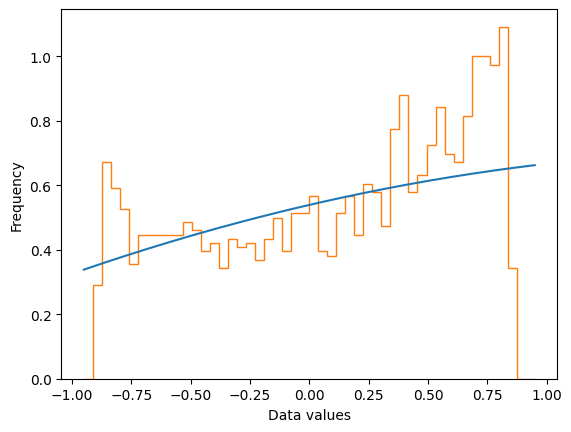

In [6]:
plt.plot(parab_lin, norm_pdf_parab(parab_lin, alpha_fit, beta_fit))
plt.stairs(values=data_counts, edges=data_edges)
plt.xlabel("Data values")
plt.ylabel("Frequency")

In [7]:
def llh_parab_pdf1(alpha, beta):
    fit_vals = norm_pdf_parab(x_accepted, alpha, beta)
    return 2 * np.sum(-np.log(fit_vals))


y_min = 0
y_max = 1
N_trials = 10_000
alpha_vals = []
beta_vals = []
for i in range(500):
    x = np.random.uniform(parab_min, parab_max, N_trials)
    y = np.random.uniform(y_min, y_max, N_trials)
    f_x = norm_pdf_parab(x, alpha_fit, beta_fit)
    x_accepted = x[y < f_x]
    minuit_boot = Minuit(llh_parab_pdf1, alpha=0.5, beta=0.5)
    minuit_boot.errordef = 0.5
    minuit_boot.migrad()
    minuit_boot.hesse()
    alpha_vals.append(minuit_boot.values["alpha"])
    beta_vals.append(minuit_boot.values["beta"])

/tmp/ipykernel_6445/2997504446.py:3: RuntimeWarning: invalid value encountered in log
  return 2 * np.sum(-np.log(fit_vals))


Text(0, 0.5, 'frequency')

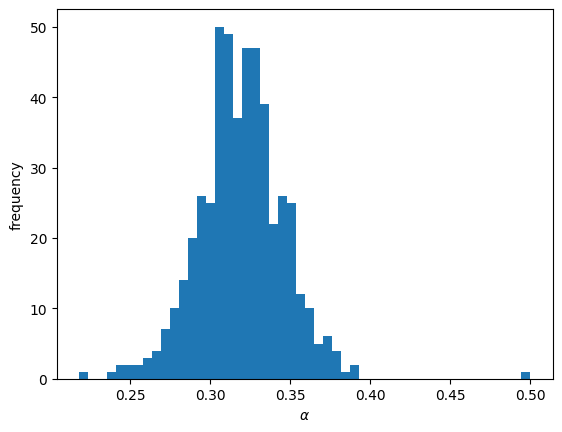

In [8]:
plt.hist(alpha_vals, bins=50)
plt.xlabel(r"$\alpha$")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

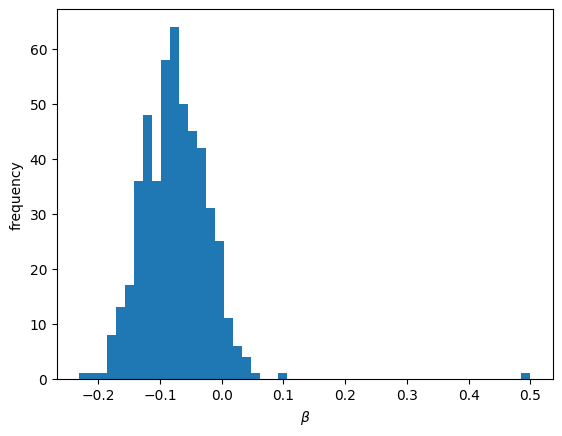

In [9]:
plt.hist(beta_vals, bins=50)
plt.xlabel(r"$\beta$")
plt.ylabel("frequency")

In [10]:
alpha_fit_boot = np.median(alpha_vals)
beta_fit_boot = np.median(beta_vals)

alpha_fit_boot = np.median(alpha_vals)
print(
    f"\nBootstrapping best fit, alpha: {alpha_fit_boot}\nBootstrapping best fit, beta: {beta_fit_boot}"
)


Bootstrapping best fit, alpha: 0.31920197106766013
Bootstrapping best fit, beta: -0.078261431428096


In [11]:
one_sig_ptcl = 16
alpha_boot_err_min = alpha_fit_boot - np.percentile(alpha_vals, one_sig_ptcl)
alpha_boot_err_max = np.percentile(alpha_vals, 100 - one_sig_ptcl) - alpha_fit_boot
beta_boot_err_min = beta_fit_boot - np.percentile(beta_vals, one_sig_ptcl)
beta_boot_err_max = np.percentile(beta_vals, 100 - one_sig_ptcl) - beta_fit_boot
print(
    f"\nBootstrap alpha error estimate -: {alpha_boot_err_min} / +: {alpha_boot_err_max}"
)
print(
    f"\nBootstrap beta error estimate -: {beta_boot_err_min} / +: {beta_boot_err_max}"
)


Bootstrap alpha error estimate -: 0.025049949870022514 / +: 0.02520219134422963

Bootstrap beta error estimate -: 0.048932493371118435 / +: 0.05233300758706721


### Fix $\alpha$ and repeat the above.

In [12]:
alpha_fix = 0.65
pdf_alpha_fix = lambda beta: llh_parab_pdf(x=data, alpha=alpha_fix, beta=beta)
minuit_alpha_fix = Minuit(pdf_alpha_fix, beta=0.5)
minuit_alpha_fix.errordef = 0.5
minuit_alpha_fix.migrad()
minuit_alpha_fix.hesse()
beta_fit_fix = minuit_alpha_fix.values[0]

pdf_alpha_fix1 = lambda beta: llh_parab_pdf1(alpha=alpha_fix, beta=beta)
beta_vals1 = []
for i in range(500):
    x = np.random.uniform(parab_min, parab_max, N_trials)
    y = np.random.uniform(y_min, y_max, N_trials)
    f_x = norm_pdf_parab(x, alpha_fix, beta_fit_fix)
    x_accepted = x[y < f_x]
    minuit_boot_fix = Minuit(pdf_alpha_fix1, beta=0.5)
    minuit_boot_fix.errordef = 0.5
    minuit_boot_fix.migrad()
    minuit_boot_fix.hesse()
    beta_vals1.append(minuit_boot_fix.values["beta"])

Text(0, 0.5, 'frequency')

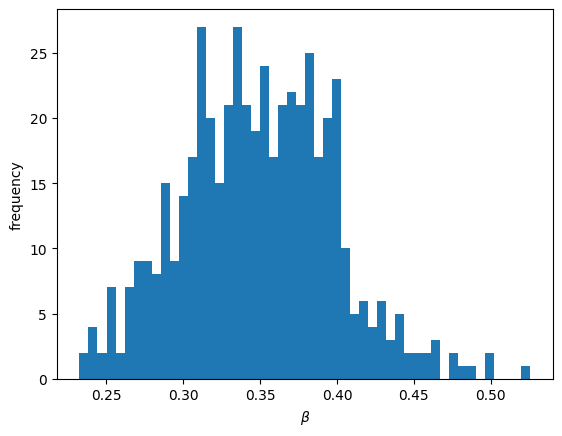

In [13]:
plt.hist(beta_vals1, bins=50)
plt.xlabel(r"$\beta$")
plt.ylabel("frequency")

In [14]:
beta_boot_fix_fit = np.median(beta_vals1)
print(
    f"\nBootstrapping best fit, beta where alpha is fixed to {alpha_fix}: {beta_boot_fix_fit}"
)


Bootstrapping best fit, beta where alpha is fixed to 0.65: 0.34753680103906737


In [15]:
beta_boot_fix_err_min = beta_boot_fix_fit - np.percentile(beta_vals1, one_sig_ptcl)
beta_boot_fix_err_max = (
    np.percentile(beta_vals1, 100 - one_sig_ptcl) - beta_boot_fix_fit
)
print(
    f"\nBootstrap beta error estimate -: {beta_boot_fix_err_min} / +: {beta_boot_fix_err_max}"
)


Bootstrap beta error estimate -: 0.04695706568699065 / +: 0.048089637153962195


### Repeat with range $-0.9\leq x \leq 0.85$

In [16]:
def pdf_new_range(x, alpha, beta):
    norm = 1 / (-0.04375 * alpha + 0.447708 * beta + 1.75)
    return norm * (1 + alpha * x + beta * x**2)


def llh_pdf_new_range(x, alpha, beta):
    fit_vals = pdf_new_range(x, alpha, beta)
    return 2 * np.sum(-np.log(fit_vals))


llh_pdf_new_range1 = lambda beta: llh_pdf_new_range(x=data, alpha=alpha_fix, beta=beta)
llh_pdf_new_range2 = lambda beta: llh_pdf_new_range(
    x=x_accepted, alpha=alpha_fix, beta=beta
)
minuit_alpha_fix1 = Minuit(llh_pdf_new_range1, beta=0.5)
minuit_alpha_fix1.errordef = 0.5
minuit_alpha_fix1.migrad()
minuit_alpha_fix1.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2067                       │              Nfcn = 29               │
│ EDM = 2.4e-08 (Goal: 0.0001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ beta │   0.99    │   0.09    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬─────────┐
│      │    beta │
├──────┼─────────┤
│ beta │ 0.00862 │
└──────┴─────────┘

In [17]:
beta_fit_fix1 = minuit_alpha_fix1.values[0]

beta_vals2 = []
parab_min1 = -0.9
parab_max1 = 0.85
for i in range(500):
    x = np.random.uniform(parab_min1, parab_max1, N_trials)
    y = np.random.uniform(y_min, y_max, N_trials)
    f_x = norm_pdf_parab(x, alpha_fix, beta_fit_fix1)
    x_accepted = x[y < f_x]
    minuit_boot_fix = Minuit(llh_pdf_new_range2, beta=0.5)
    minuit_boot_fix.errordef = 0.5
    minuit_boot_fix.migrad()
    minuit_boot_fix.hesse()
    beta_vals2.append(minuit_boot_fix.values["beta"])

Text(0, 0.5, 'frequency')

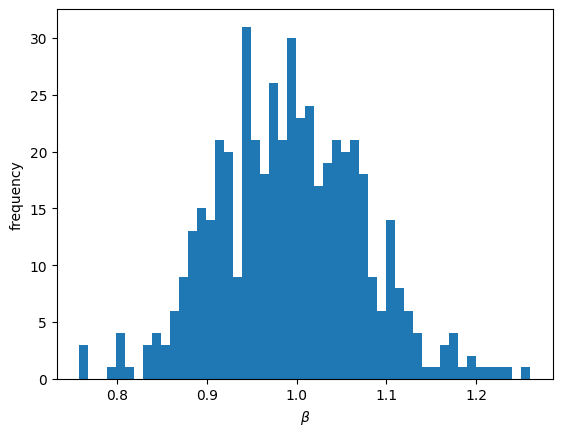

In [18]:
plt.hist(beta_vals2, bins=50)
plt.xlabel(r"$\beta$")
plt.ylabel("frequency")

In [19]:
beta_boot_fix_fit1 = np.median(beta_vals2)
print(
    f"\nBootstrapping best fit, beta where alpha is fixed to {alpha_fix}: {beta_boot_fix_fit1}"
)


Bootstrapping best fit, beta where alpha is fixed to 0.65: 0.9907674382003058


In [20]:
beta_boot_fix_err_min1 = beta_boot_fix_fit1 - np.percentile(beta_vals2, one_sig_ptcl)
beta_boot_fix_err_max1 = (
    np.percentile(beta_vals2, 100 - one_sig_ptcl) - beta_boot_fix_fit1
)
print(
    f"\nBootstrap beta error estimate -: {beta_boot_fix_err_min1} / +: {beta_boot_fix_err_max1}"
)


Bootstrap beta error estimate -: 0.08012672201430837 / +: 0.0800475860531562


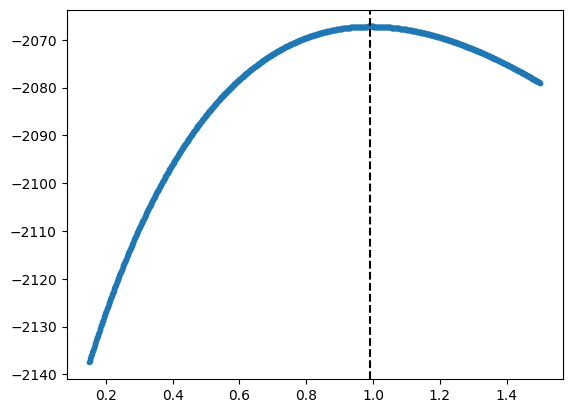

In [21]:
beta_lin = np.linspace(0.15, 1.5, 1000)
llh_beta = -np.array([llh_pdf_new_range1(beta) for beta in beta_lin])
plt.plot(beta_lin, llh_beta, ".")
plt.axvline(beta_fit_fix1, color="black", ls="dashed")

In [22]:
llh_max_1sig = llh_beta.max() - 1
beta_1sig_llh_min = (
    beta_fit_fix1
    - beta_lin[: np.argmax(llh_beta)][
        np.argmin(np.abs(llh_beta[: np.argmax(llh_beta)] - llh_max_1sig))
    ]
)
beta_1sig_llh_max = (
    beta_lin[np.argmax(llh_beta) :][
        np.argmin(np.abs(llh_beta[np.argmax(llh_beta) :] - llh_max_1sig))
    ]
    - beta_fit_fix1
)

print(
    f"\nLikelihood beta error estimate -: {beta_1sig_llh_min} / +: {beta_1sig_llh_max}"
)


Likelihood beta error estimate -: 0.1265518862763002 / +: 0.13561027588586194


In [23]:
N_mesh = 200
alpha_mesh, beta_mesh = np.meshgrid(
    np.linspace(0, 1, N_mesh), np.linspace(0, 1, N_mesh)
)
pdf_mesh = pdf_new_range(
    data[np.newaxis, :],
    alpha_mesh.reshape(-1, 1),
    beta_mesh.reshape(-1, 1),
)
llh_pdf_mesh = np.sum(np.log(pdf_mesh), axis=1).reshape(N_mesh, N_mesh)

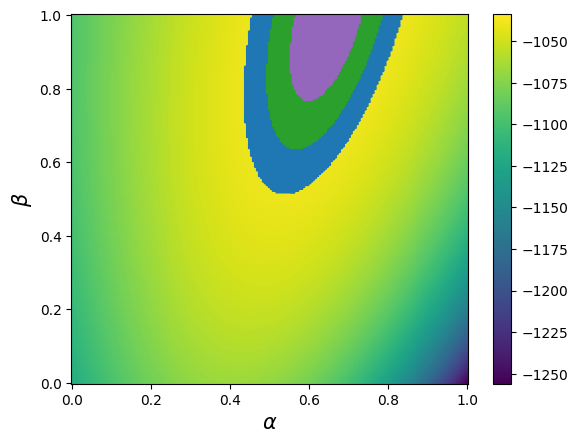

In [24]:
onesig_llh_cutoff = 1.15
twosig_llh_cutoff = 3.09
threesig_llh_cutoff = 5.92
plt.pcolormesh(alpha_mesh, beta_mesh, llh_pdf_mesh)
plt.plot(
    alpha_mesh[
        (llh_pdf_mesh >= (llh_pdf_mesh.max() - threesig_llh_cutoff))
        & (llh_pdf_mesh <= (llh_pdf_mesh.max() + threesig_llh_cutoff))
    ],
    beta_mesh[
        (llh_pdf_mesh >= (llh_pdf_mesh.max() - threesig_llh_cutoff))
        & (llh_pdf_mesh <= (llh_pdf_mesh.max() + threesig_llh_cutoff))
    ],
    llh_pdf_mesh[
        (llh_pdf_mesh >= (llh_pdf_mesh.max() - threesig_llh_cutoff))
        & (llh_pdf_mesh <= (llh_pdf_mesh.max() - threesig_llh_cutoff))
    ],
)
plt.plot(
    alpha_mesh[
        (llh_pdf_mesh >= (llh_pdf_mesh.max() - twosig_llh_cutoff))
        & (llh_pdf_mesh <= (llh_pdf_mesh.max() + twosig_llh_cutoff))
    ],
    beta_mesh[
        (llh_pdf_mesh >= (llh_pdf_mesh.max() - twosig_llh_cutoff))
        & (llh_pdf_mesh <= (llh_pdf_mesh.max() + twosig_llh_cutoff))
    ],
    llh_pdf_mesh[
        (llh_pdf_mesh >= (llh_pdf_mesh.max() - twosig_llh_cutoff))
        & (llh_pdf_mesh <= (llh_pdf_mesh.max() - twosig_llh_cutoff))
    ],
)

plt.plot(
    alpha_mesh[
        (llh_pdf_mesh >= (llh_pdf_mesh.max() - onesig_llh_cutoff))
        & (llh_pdf_mesh <= (llh_pdf_mesh.max() + onesig_llh_cutoff))
    ],
    beta_mesh[
        (llh_pdf_mesh >= (llh_pdf_mesh.max() - onesig_llh_cutoff))
        & (llh_pdf_mesh <= (llh_pdf_mesh.max() + onesig_llh_cutoff))
    ],
    llh_pdf_mesh[
        (llh_pdf_mesh >= (llh_pdf_mesh.max() - onesig_llh_cutoff))
        & (llh_pdf_mesh <= (llh_pdf_mesh.max() - onesig_llh_cutoff))
    ],
)
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel(r"$\beta$", fontsize=15)
plt.colorbar()

In [25]:
def pdf_final_range(x, alpha, beta):
    norm = 3 / (2 * (beta + 3))
    return norm * (1 + alpha * x + beta * x**2)


def llh_final_range(x, alpha, beta):
    fit_vals = pdf_final_range(x, alpha, beta)
    return -2 * np.sum(np.log(fit_vals))


data2_path = "https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2024/data/MLE_Variance_data.txt"
data2_x1, data2_x2 = pd.read_csv(
    data2_path, delimiter="\s", names=["x1", "x2"]
).T.values

/tmp/ipykernel_6445/590648997.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data2_x1, data2_x2 = pd.read_csv(


In [26]:
llh_fin_x1 = lambda alpha, beta: llh_final_range(x=data2_x1, alpha=alpha, beta=beta)
llh_fin_x2 = lambda alpha, beta: llh_final_range(x=data2_x2, alpha=alpha, beta=beta)

minuit_fin_x1 = Minuit(llh_fin_x1, alpha=0.5, beta=0.5)
minuit_fin_x2 = Minuit(llh_fin_x2, alpha=0.01, beta=0.5)
fin_lin = np.linspace(-1, 1, 1000)

In [27]:
minuit_fin_x1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2737                       │              Nfcn = 46               │
│ EDM = 2.53e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha │   0.02    │   0.05    │            │            │         │         │       │
│ 1 │ beta  │   0.54    │   0.11    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────┐
│       │   alpha    beta │
├───────┼─────────────────┤
│ alpha │ 0.00235  0.0006 │
│  beta │  0.0006  0.0119 │
└───────┴─────────────────┘

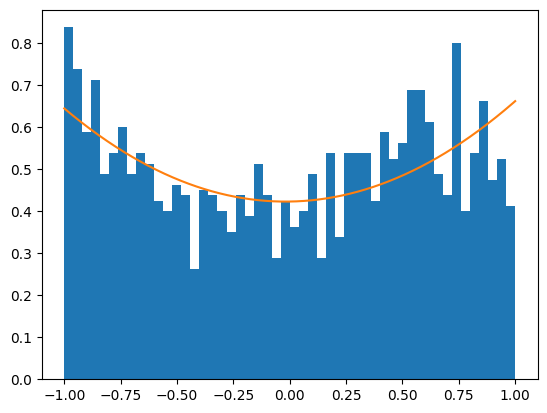

In [28]:
plt.hist(data2_x1, bins=50, density=True)
plt.plot(fin_lin, pdf_final_range(fin_lin, *minuit_fin_x1.values[:]))

In [29]:
minuit_fin_x2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1962                       │              Nfcn = 50               │
│ EDM = 5.73e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha │   1.38    │   0.07    │            │            │         │         │       │
│ 1 │ beta  │   0.87    │   0.11    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────┐
│       │   alpha    beta │
├───────┼─────────────────┤
│ alpha │ 0.00494   0.006 │
│  beta │   0.006  0.0124 │
└───────┴─────────────────┘

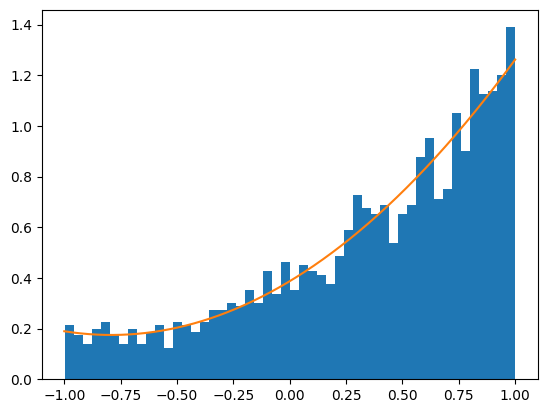

In [30]:
plt.hist(data2_x2, bins=50, density=True)
plt.plot(fin_lin, pdf_final_range(fin_lin, *minuit_fin_x2.values[:]))